In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Hyperparameter

In [2]:
SEQ_LEN = 21 # 6, 11, 21
SPLIT = 0.80 # 0.80, 0.90
LSTM_Layer = 3 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

In [3]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'SGD/IDR']

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[2]}'
data = pd.read_csv(url)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1959 non-null   datetime64[ns]
 1   Close   1959 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.7 KB


## Preprocessing

In [4]:
scaler = MinMaxScaler()
close_price = data.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [5]:
print("----------- Normalize Data Shape -----------")
print(scaled_close.shape)
print("\n----------- Normalize Data -----------")
print(scaled_close)

----------- Normalize Data Shape -----------
(1959, 1)

----------- Normalize Data -----------
[[0.13503666]
 [0.14700219]
 [0.13068802]
 ...
 [0.57488343]
 [0.59368865]
 [0.59277804]]


In [5]:
def to_sequences(data, seq_len):
    """
    Converts a list of data into a sequence of equal length.

    Args:
        data: A list of numerical values.
        seq_len: An integer indicating the length of each sequence.

    Returns:
        A numpy array of shape (len(data) - seq_len, seq_len) containing the sequences.
    """
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    """
    Preprocesses the raw data for training and testing.

    Args:
        data_raw: A list of numerical values.
        seq_len: An integer indicating the length of each sequence.
        train_split: A float between 0 and 1 indicating the fraction of data to use for training.

    Returns:
        A tuple of four numpy arrays: (X_train, y_train, X_test, y_test).
        X_train and X_test are the input sequences for training and testing, respectively.
        y_train and y_test are the output values for training and testing, respectively.
    """
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

## Genetic Algorithm

In [6]:
# Genetic Algorithm
def genetic_algorithm(population_size, generations):
    """
    Performs a genetic algorithm optimization.

    This function creates an initial population and then performs selection, crossover, and mutation operations for a specified number of generations. The fitness of each chromosome in the population is evaluated using the fitness_function.

    Args:
        population_size (int): The size of the population.
        generations (int): The number of generations to run the genetic algorithm.

    Returns:
        tuple: The best chromosome and its fitness score.
    """
    population = np.random.randint(1, high=26, size=(population_size, 3))
    
    for generation in range(generations):
        print(f"Generation - {generation + 1}")
        fitness_scores = np.array([fitness_function(chromosome) for chromosome in population])
        best_chromosome = population[np.argmax(fitness_scores)]
        best_fitness = np.max(fitness_scores)
        
        new_population = []
        
        while len(new_population) < population_size:
            parent1 = selection(population, fitness_scores)
            parent2 = selection(population, fitness_scores)
            offspring_1, offspring_2 = crossover(parent1, parent2)
            mutate(offspring_1)
            mutate(offspring_2)
            new_population.append(offspring_1)
            new_population.append(offspring_2)
        
        population = np.array(new_population)
    
    return best_chromosome, best_fitness

# Selection (Tournament selection)
def selection(population, fitness_scores, tournament_size=3):
    """
    Performs tournament selection on a population.

    Args:
        population: A list of individuals.
        fitness_scores: A list of fitness scores corresponding to each individual in the population.
        tournament_size: An integer indicating the number of individuals to select for the tournament.

    Returns:
        The individual from the tournament with the highest fitness score.
    """
    indices = np.random.randint(len(population), size=tournament_size)
    tournament = population[indices]
    tournament_fitness = fitness_scores[indices]
    return tournament[np.argmax(tournament_fitness)]

# Crossover (Single-point crossover)
def crossover(parent1, parent2):
    """
    Performs single-point crossover on two parents.

    Args:
        parent1: The first parent individual.
        parent2: The second parent individual.

    Returns:
        Two offspring individuals resulting from the crossover of the input parents.
    """
    crossover_point = np.random.randint(1, len(parent1))
    offspring_1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    offspring_2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return offspring_1, offspring_2

# Mutation (Swap Mutation)
def mutate(chromosome, mutation_rate=0.01):
    """
    Performs swap mutation on a chromosome.

    Args:
        chromosome: The individual to be mutated.
        mutation_rate: The probability of each gene being mutated.

    Returns:
        None. The input chromosome is mutated in-place.
    """
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            j = np.random.randint(len(chromosome))
            chromosome[i], chromosome[j] = chromosome[j], chromosome[i]

# Fitness Function
def fitness_function(chromosome):
    """
    Optimizes the fitness function.

    This function builds, trains, and evaluates an LSTM model using the provided chromosome. The fitness score is calculated as the negative value of the loss.

    Args:
        chromosome (list): A list of values used to determine the number of units in each LSTM layer.

    Returns:
        float: The fitness score of the model.
    """
    lstm_units = [int(chromosome[i]*10) or default for i, default in enumerate([128, 64, 32])]

    # Build the LSTM model
    tf.keras.backend.clear_session()
    model = Sequential()
    for i, units in enumerate(lstm_units[:LSTM_Layer]):
        model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    
    # Compile and train the model
    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    model.fit(X_train, y_train,
              epochs=10,
              batch_size=32,
              verbose=0,
              validation_split=0.1)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)

    # Return the negative value of the loss as the fitness score
    return -loss

In [7]:
import typing
from datetime import datetime

def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    """
    Calculates the time elapsed since the provided start time.

    This function returns the current time if no start time is provided. If a start time is provided, it calculates the time elapsed since the start time and returns it in the format of "hours minutes and seconds".

    Args:
        start_time (datetime, optional): The start time. Defaults to None.

    Returns:
        typing.Union[datetime.datetime, str]: The current time if no start time is provided, otherwise the time elapsed since the start time.
    """
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [8]:
# Do not increase this value
population_size = 5
generations = 25

time = timer(None)
best_chromosome, best_fitness = genetic_algorithm(population_size, generations)
time = timer(time)

Generation - 1
13/13 [==============================] - 0s 4ms/step - loss: 7.1623e-04
Generation - 2
13/13 [==============================] - 0s 4ms/step - loss: 7.9900e-04
Generation - 3
13/13 [==============================] - 0s 6ms/step - loss: 7.6123e-04
Generation - 4
13/13 [==============================] - 0s 4ms/step - loss: 9.1965e-04
Generation - 5
13/13 [==============================] - 0s 4ms/step - loss: 9.1264e-04
Generation - 6
13/13 [==============================] - 0s 4ms/step - loss: 7.5487e-04
Generation - 7
13/13 [==============================] - 0s 4ms/step - loss: 0.0018
Generation - 8
13/13 [==============================] - 0s 4ms/step - loss: 8.1083e-04
Generation - 9
13/13 [==============================] - 0s 4ms/step - loss: 7.6022e-04
Generation - 10
13/13 [==============================] - 0s 4ms/step - loss: 7.4261e-04
Generation - 11
13/13 [==============================] - 0s 4ms/step - loss: 0.0029
Generation - 12
13/13 [==========================

In [9]:
print("Best Chromosome:", best_chromosome)
print("Best Fitness:", best_fitness)
print("Time Taken:", time)

Best Chromosome: [15  9 11]
Best Fitness: -0.0010635937796905637
Time Taken: 0 hours 30 minutes and 54.45 seconds.


## Re-Training Model with Best Parameter

In [10]:
model = Sequential()
for i, units in enumerate(best_chromosome[:LSTM_Layer]):
    model.add(LSTM(units*10, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 150)           91200     
                                                                 
 lstm_4 (LSTM)               (None, 20, 90)            86760     
                                                                 
 lstm_5 (LSTM)               (None, 110)               88440     
                                                                 
 dense_1 (Dense)             (None, 1)                 111       
                                                                 
Total params: 266,511
Trainable params: 266,511
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='mean_squared_error',
              metrics=['mae', RootMeanSquaredError()],
              optimizer='adam')

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/50
44/44 [==============================] - 6s 32ms/step - loss: 0.0113 - mae: 0.0725 - root_mean_squared_error: 0.1061 - val_loss: 0.0017 - val_mae: 0.0336 - val_root_mean_squared_error: 0.0407
Epoch 2/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0045 - mae: 0.0418 - root_mean_squared_error: 0.0669 - val_loss: 6.9125e-04 - val_mae: 0.0219 - val_root_mean_squared_error: 0.0263
Epoch 3/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0040 - mae: 0.0386 - root_mean_squared_error: 0.0635 - val_loss: 6.7860e-04 - val_mae: 0.0214 - val_root_mean_squared_error: 0.0260
Epoch 4/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0036 - mae: 0.0354 - root_mean_squared_error: 0.0601 - val_loss: 7.1136e-04 - val_mae: 0.0211 - val_root_mean_squared_error: 0.0267
Epoch 5/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0035 - mae: 0.0348 - root_mean_squared_error: 0.0589 - val_loss: 5.5147e-04 - val_mae: 0.0187 - val_root

In [12]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 5ms/step - loss: 4.2577e-04 - mae: 0.0159 - root_mean_squared_error: 0.0206


[0.00042576921987347305, 0.015850573778152466, 0.020634176209568977]

## Model Evaluation

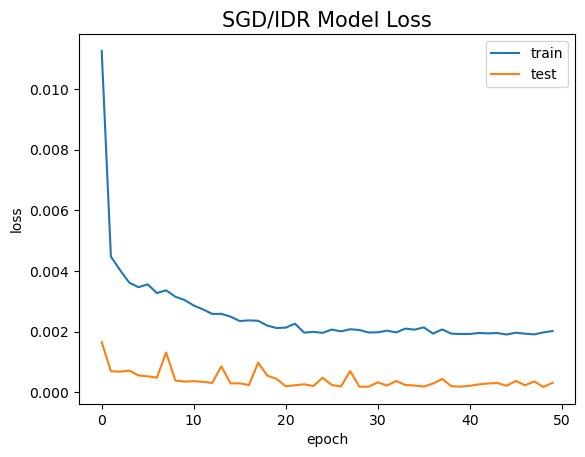

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{SHEET_NAME[2]} Model Loss', fontsize=15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [14]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

13/13 [==============================] - 1s 4ms/step


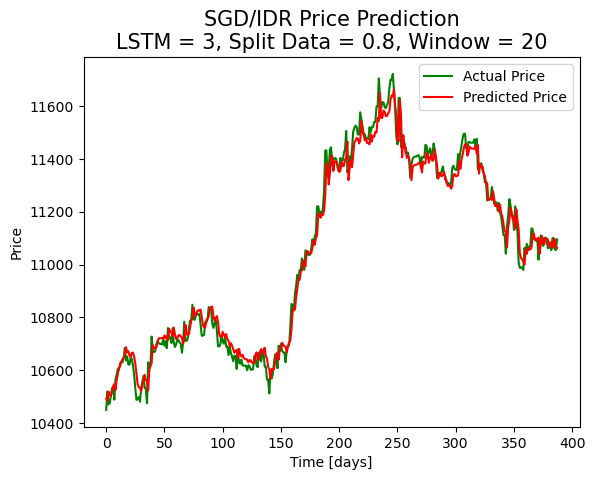

In [15]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title(f'{SHEET_NAME[2]} Price Prediction\nLSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}', fontsize=15)
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [16]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Mean Squared Error for prediction :", mse)
    print("Root Mean Squared Error for prediction :", rmse)
    return mae, mse, rmse

print(f"LSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}")
print("\n----------------- Normalized Error -----------------")
mae, mse, rmse = matrices(y_test, y_hat)
print("\n----------------- Actual Error -----------------")
mae_inverse, mse_inverse, rmse_inverse = matrices(y_test_inverse, y_hat_inverse)

LSTM = 3, Split Data = 0.8, Window = 20

----------------- Normalized Error -----------------
Mean Absolute Error for prediction : 0.015850575183731893
Mean Squared Error for prediction : 0.0004257692332214638
Root Mean Squared Error for prediction : 0.020634176339787924

----------------- Actual Error -----------------
Mean Absolute Error for prediction : 33.420260248872395
Mean Squared Error for prediction : 1892.7954276287062
Root Mean Squared Error for prediction : 43.50626883138459
